In [ ]:
# https://scikit-learn.org/stable/modules/permutation_importance.html

In [1]:
!pip install -q scikit-optimize xgboost GPUtil
!wget -qO model_template.py https://github.com/HigherGround189/EGT309-Team-Harish-Kanna/raw/refs/heads/main/src/egt309_pipeline/model_template.py
!wget -qO model_template_utils.py https://github.com/HigherGround189/EGT309-Team-Harish-Kanna/raw/refs/heads/main/src/egt309_pipeline/model_template_utils.py

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.9 MB/s eta 0:00:00


In [2]:
# Misc
RANDOM_STATE = 42

In [3]:
import GPUtil
import matplotlib.pyplot as plt
import pandas as pd
from model_template import *
from model_template_utils import *
from sklearn.model_selection import StratifiedKFold, train_test_split

In [4]:
device = "cuda" if GPUtil.getAvailable() else "cpu"

# Data splitting

In [5]:
!gdown --fuzzy https://drive.google.com/file/d/17qgFjTIUgxsiURgGjVC6WlEFn6Wl-OeJ/view?usp=sharing

Downloading...
From: https://drive.google.com/uc?id=17qgFjTIUgxsiURgGjVC6WlEFn6Wl-OeJ
To: /content/cleaned_bmarket.csv
100% 2.65M/2.65M [00:00<00:00, 62.4MB/s]


In [6]:
df = pd.read_csv("./cleaned_bmarket.csv")

In [7]:
y = df["Subscription Status"]
X = df.drop("Subscription Status", axis=1)

X = pd.get_dummies(X, drop_first=True)  # PLEASE rememeber to research label encoder >.<

In [8]:
print(X.shape, y.shape)

(40787, 26) (40787,)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

In [ ]:
print(X_train.shape, y_train.shape)

(32629, 26) (32629,)


# Misc

In [10]:
from skopt.space import Categorical, Integer, Real

In [11]:
###################
# Hyperparameters #
###################

# Random Forest: {
rf_params = {
    "n_jobs": 1,
    "oob_score": True,
    "warm_start": False,
    "random_state": RANDOM_STATE,
}

# rf_gs_params = {
#     "max_features": ["log2"],
#     "min_samples_split": [2, 5, 10],
#     'max_samples': [0.75, None,],
#     "class_weight": ["balanced", None],
#     "max_depth": [20, None],
#     "n_estimators": [1500, 2000],
# }

rf_bayes_params = {
    "max_features": Categorical(["sqrt", "log2"]),
    "min_samples_split": Integer(2, 25),
    "max_samples": Real(0.5, 1.0),
    "class_weight": Categorical(["balanced", None]),
    "max_depth": Integer(10, 300),
    "n_estimators": Integer(200, 1000),
}
# }

# Ensemble models

### Random Forest

**Optimization Methods**


*   Grid Search
*   Adjusting decision threshold

Only boosting trees plot training and validation loss


In [12]:
from sklearn.ensemble import RandomForestClassifier

In [13]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [14]:
rf_ens = ModelWrapper(
    title="RandomForestClassifier",
    model=RandomForestClassifier,
    hyperparameters={**rf_params},
    param_grid={**rf_bayes_params},
    cv=cv_strategy,
    n_iterations=5,
)

In [15]:
clfs = [rf_ens]

In [16]:
for model in clfs:
    model.run_bayessearch(X_train, y_train)
    model.write_info_to_disk(X_test, y_test, "/content")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [17]:
pd.read_csv("./RandomForestClassifier/test_error.csv")

,Unnamed: 0,test
0,accuracy,0.835744
1,precision,0.308113
2,recall,0.367791
3,f1,0.335317


In [18]:
from sklearn.metrics import roc_auc_score, roc_curve

y_pred_proba = rf_ens.best_model.predict_proba(X)[:, 1]
fpr, tpr, _ = roc_curve(y, y_pred_proba)
auc_score = roc_auc_score(y, y_pred_proba)

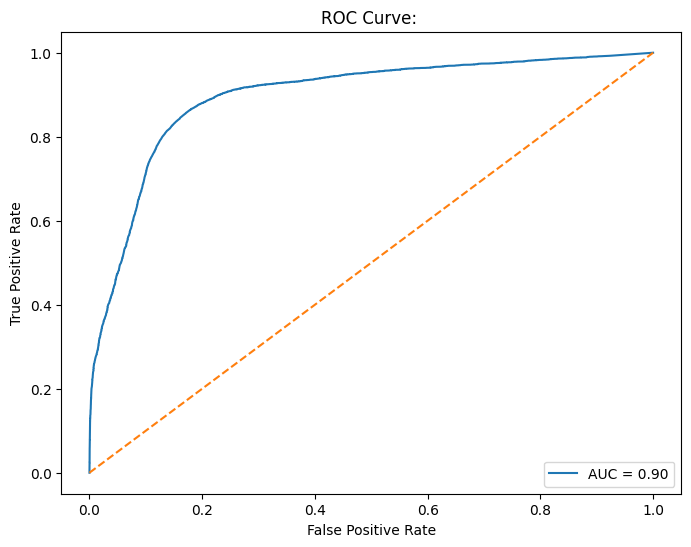

In [19]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: ")
plt.legend(loc=4)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
y_pred = rf_ens.best_model.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.92      0.88      0.90      7239
        True       0.31      0.43      0.36       919

    accuracy                           0.83      8158
   macro avg       0.62      0.66      0.63      8158
weighted avg       0.86      0.83      0.84      8158



## XGBoost